# Исследование интернет-магазина

От отдела аналитики совместно с отделом маркетинга крупного интернет-магазина подготовлен список гипотез для увеличения выручки. Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

<font size=+1><b>Описание данных:</b></font><br>
В основных данных есть список гипотез, которые необходимо проверить, и данные о пользователях и заказах с проведённого A/B-теста.

<font size=+0.5><b>Гипотезы</b></font><br>
Данные с гипотезами отдела маркетинга hypothesis.csv
- `Hypothesis` — краткое описание гипотезы,
- `Reach` — охват пользователей по 10-балльной шкале,
- `Impact` — влияние на пользователей по 10-балльной шкале,
- `Confidence` — уверенность в гипотезе по 10-балльной шкале,
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение `Efforts`, тем дороже проверка гипотезы.

<font size=+0.5><b>Заказы</b></font><br>
Данные о заказах пользователей orders.csv
- `transactionId` — идентификатор заказа,
- `visitorId` —  идентификатор пользователя, совершившего заказ,
- `date` — дата, когда был совершён заказ,
- `revenue` — выручка заказа,
- `group` —  группа A/B-теста, в которую попал заказ.

<font size=+0.5><b>Посетители</b></font><br>
Данные о посетителях за каждый день тестирования visitors.csv
- `date` — дата,
- `group` — группа A/B-теста,
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста.

<font size=+1><b>План работы:</b></font><br>
- Применить фреймворк ICE для приоритизации гипотез
- Применить фреймворк RICE для приоритизации гипотез
- Сделать выводы о приоритизации гипотез
- Загрузить и изучить данные
- Найти и изучить пропуски в данных, дубликаты и аномалии
- Провести анализ A/B-теста
- Изучить кумулятивную выручки по группам
- Изучить кумулятивный средний чек по группам
- Изучить относительное изменение кумулятивного среднего чека группы B к группе A
- Изучить кумулятивное среднее количество заказов на посетителя по группам
- Изучить относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A
- Выбрать границу количества заказов на пользователя для определения аномальных пользователей
- Выбрать границу стоимости заказов для определения аномальных пользователей
- Посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным
- Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным
- Посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным
- Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным
- Принять решение по результатам теста:
    - остановить тест, зафиксировав победу одной из групп
    - остановить тест, зафиксировав отсутствие различий между группами
    - продолжить тест
- Сделать выводы

# Часть 1. Приоритизация гипотез

## Загрузка данных по приоритизации гипотез

### Используемые библиотеки и функции

Загрузим необходимые в проекте библиотеки:

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

In [2]:
import matplotlib
%config InlineBackend.figure_format = 'retina'
matplotlib.style.use('fivethirtyeight')
plt.rc('figure', figsize=(20, 8))

In [3]:
# функция для загрузки данных
def main_info (dataset):
    data = pd.read_csv(dataset)
    pd.set_option('max_colwidth', 200)
    display(data.head())
    print('------------------------------------------')
    display('Основная информация по столбцам таблицы:')
    display(data.info())
    print('-------------------------------------')
    display('Доля пропусков по столбцам таблицы:')
    display(pd.DataFrame(round(data.isna().mean()\
                               .sort_values(ascending=False), 3))\
                        .style.format('{:.1%}')\
                        .background_gradient('coolwarm'))
    print('---------------------------------')
    display('Основная информация по таблице:')
    display(data.describe().style.format('{:.1f}'))
    print('----------------------------------------')
    display('Количество явных дубликатов в таблице:')
    display(data.duplicated().sum())
    return data

In [4]:
# функция для создания сводной таблицы
def table_pivot(data, col_group, values, func):
    return data.groupby(by=col_group, as_index=False)\
               .agg(total = (values, func))

In [5]:
# функция для создания таблицы количества и суммы заказов по датам в группе
def order_daily(data):
    return data.groupby('date', as_index=False)\
               .agg(transaction_id = ('transaction_id', 'nunique'),
                    revenue = ('revenue', 'sum')) 

In [6]:
# функция для подсчёта числа заказов каждого пользователя группы
def orders_by_user(df):
    return pd.concat([df['orders'],
                     pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() \
                                                   - len(df['orders'])),
                               name='orders')], axis=0)

In [7]:
# функция для проверки гипотез
def test_hipot(groupA, groupB, test):
    p_value = st.mannwhitneyu(groupA, groupB)[1]
    print(f'{test} в группе А: ', "{0:.3f}".format(groupA.mean()))
    print(f'{test} в группе B: ', "{0:.3f}".format(groupB.mean()))
    
    print('p-значение: ', "{0:.3}".format(p_value))

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        print('')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        print('')

### Загрузка данных и основная информация

Посмотрим на основную информацию из таблицы с гипотезами:

In [8]:
hypothesis = main_info('hypothesis.csv')

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


------------------------------------------


'Основная информация по столбцам таблицы:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

-------------------------------------


'Доля пропусков по столбцам таблицы:'

,0
Hypothesis,0.0%
Reach,0.0%
Impact,0.0%
Confidence,0.0%
Efforts,0.0%


---------------------------------


'Основная информация по таблице:'

,Reach,Impact,Confidence,Efforts
count,9.0,9.0,9.0,9.0
mean,4.8,4.8,5.6,4.9
std,3.2,3.2,3.0,2.8
min,1.0,1.0,1.0,1.0
25%,3.0,3.0,3.0,3.0
50%,3.0,3.0,7.0,5.0
75%,8.0,7.0,8.0,6.0
max,10.0,10.0,9.0,10.0


----------------------------------------


'Количество явных дубликатов в таблице:'

0

- В таблице содержится 5 столбцов и 9 записей с параметрами гипотез. 
- Дубликатов в таблице нет, пропусков тоже. 
- Все параметры являются целочисленными значениями. 
- Данные уже готовы для дальнейшей работы с ними.

### Применение фреймворка ICE

Применим фреймворк ICE для того, чтобы расставить приоритеты гипотезам.

In [9]:
hypothesis['ICE'] = round((hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts'])
hypothesis.sort_values(by='ICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.0


На первом месте по приоритету находится гипотеза о запуске скидки на товар в день рождения. На втором месте - увеличение каналов привлечения трафика, чтобы привлечь больше пользователей. На третьем месте - добавление формы подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.

На данный момент гипотезы, которые не заслуживают внимания это: 
- запуск собственной службы доставки для сокращения срока доставки заказов
- изменение структур категорий для увеличения конверсии
- изменение цвета фона главной страницы для увеличения вовлечённости пользователей 
- добавление страницы отзывов клиентов о магазине.

Они все получили достаточно низкие баллы. В целом, это объяснимо. Так как для тестирования данных гипотез либо нужно менять логистику (создание собственной службы доставки или изменение структур категорий товаров) с большими затратами ресурсов, либо это гипотезы, от которых не ожидается особого выхлопа, несмотря на маленькие затраты ресурсов для их проверки (изменение цвета фона гланвой страницы или добавление страницы с отзывами клиентов).

### Применение фреймворка RICE

Применим модификацию фреймворка RICE, чтобы учесть в формуле ожидаемую оценку пользователей, которых затронет изменение.

In [10]:
hypothesis['RICE'] = round((hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence']) \
                           / hypothesis['Efforts'])
hypothesis.sort_values(by='RICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.0,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.0,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.0,16.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.0,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.0,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0,3.0


Можно увидеть, что при учёте оценки ожидаемого охвата пользователей, гипотезы с самым низким приоритетом не поменялись, зато сильно изменился список гипотез, которые лучше всего проверять в первую очередь. Так на первое место вышла гипотеза о добавление формы подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок. На второе место попала гипотеза о добавлении блоков рекомендаций товаров на сайте интернет магазина, и при этом эта гипотеза по ресурсоёмкости приемлемая, что позволит протестировать её без особых трудностей. 

Гипотеза об акции в день рождения по формуле RICE ушла на пятое место, потому что затронет лишь малый процент пользователей. И это несмотря на то, что у этой гипотезы были высокие оценки о влиянии её на пользователей и оценка уверенности в гипотезе.

### Промежуточные выводы по приоритезации гипотез:

- Гипотезы, которые были в самом низу списка приоритета по формуле ICE, по формуле RICE остались там же.
- Благодаря добавлению дополнительного параметра с оценкой охвата пользователей, которых коснётся изменение, поменялся приоритет гипотез. Так, на первое место вышла гипотеза со сбором базы клиентов для email-рассылок, а акция в день рождения спустилась на пятое место, ведь она охватила бы небольшое количество пользователей.
- Учитывать параметр с оценкой охвата пользователей полезно, так как он даёт представление о том, скольких пользователей затронет изменение, которое мы собираемся внести.

# Часть 2. Анализ A/B-теста

## Загрузка данных A/B-теста

### Загрузка данных и основная информация

#### Заказы

Посмотрим на основную информацию из таблицы с заказами:

In [11]:
orders = main_info('orders.csv')

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


------------------------------------------


'Основная информация по столбцам таблицы:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

-------------------------------------


'Доля пропусков по столбцам таблицы:'

,0
transactionId,0.0%
visitorId,0.0%
date,0.0%
revenue,0.0%
group,0.0%


---------------------------------


'Основная информация по таблице:'

,transactionId,visitorId,revenue
count,1197.0,1197.0,1197.0
mean,2155621385.5,2165960143.1,8348.0
std,1229084904.8,1236014192.1,39191.1
min,1062393.0,5114589.0,50.0
25%,1166775572.0,1111826046.0,1220.0
50%,2145193898.0,2217984702.0,2978.0
75%,3237740112.0,3177606451.0,8290.0
max,4293855558.0,4283872382.0,1294500.0


----------------------------------------


'Количество явных дубликатов в таблице:'

0

- В таблице 5 столбцов и 1197 записей с информацией о заказах. 
- В данных нет пропусков и явных дубликатов. 
- Столбец с датой имеет имеет тип данных "объект", а не "дата".
- В столбце со стоимостью заказов встречаются как очень маленькие суммы за заказ (50), так и аномально большие (1294500). 
- Такие аномалии нужно будет изучить подробнее, ведь основная масса чеков за заказ находится от 1220 до 8290.

#### Посетители

Посмотрим на основную информацию из таблицы с посетителями:

In [12]:
visitors = main_info('visitors.csv')

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


------------------------------------------


'Основная информация по столбцам таблицы:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

-------------------------------------


'Доля пропусков по столбцам таблицы:'

,0
date,0.0%
group,0.0%
visitors,0.0%


---------------------------------


'Основная информация по таблице:'

,visitors
count,62.0
mean,607.3
std,114.4
min,361.0
25%,534.0
50%,624.5
75%,710.5
max,770.0


----------------------------------------


'Количество явных дубликатов в таблице:'

0

- В таблице 3 столбца и 62 записи с информацией о пользователях. 
- В таблице нет пропусков данных и явных дубликатов.
- Столбец с датой имеет тип данных "объект", который нужно будет сменить на "дата".

## Предобработка данных

Приведём столбцы с датой к правильному типу данных:

In [13]:
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

Посмотрим на названия столбцов. Приведём название столбцов к принятому стилю.

In [14]:
orders.columns

Index(['transactionId', 'visitorId', 'date', 'revenue', 'group'], dtype='object')

In [15]:
orders = orders.rename(columns={'transactionId': 'transaction_id',
                                'visitorId': 'visitor_id'})

### Пользователи по группам

Посмотрим общее количество пользователей в группах А и В.

In [16]:
df = table_pivot(data=visitors, col_group='group', values='visitors', func='sum')
df['part'] = df['total'] / df['total'].sum()
df.style.format({'part': '{:.1%}'})

,group,total,part
0,A,18736,49.8%
1,B,18916,50.2%


В группах А и В за все дни испытаний отличие меньше, чем на 200 пользователей, что составляет отличие на 0.4%.

### Динамика набора

Проверим динамику набора пользователей в тестовые группы.

In [17]:
date_A = visitors.query('group == "A"')
date_B = visitors.query('group == "B"')
date_AB = date_A.merge(date_B, left_on='date', right_on='date', how='left')
date_AB['date'] = date_AB['date'].dt.date
date_AB['A_share'] = (date_AB['visitors_x'] / (date_AB['visitors_x'] + date_AB['visitors_y']))
date_AB['B_share'] = (date_AB['visitors_y'] / (date_AB['visitors_x'] + date_AB['visitors_y']))
date_AB['B_to_A_group'] = (1 - date_AB['B_share'] / date_AB['A_share'])
date_AB = date_AB[['date', 'visitors_x', 'A_share', 'visitors_y', 'B_share', 'B_to_A_group']]
date_AB = date_AB.rename(columns={'visitors_x':'A', 'visitors_y':'B'})
date_AB.style.format({'A_share':'{:.1%}', 'B_share':'{:.1%}', 'B_to_A_group':'{:.1%}'})

,date,A,A_share,B,B_share,B_to_A_group
0,2019-08-01,719,50.2%,713,49.8%,0.8%
1,2019-08-02,619,51.6%,581,48.4%,6.1%
2,2019-08-03,507,49.9%,509,50.1%,-0.4%
3,2019-08-04,717,48.2%,770,51.8%,-7.4%
4,2019-08-05,756,51.7%,707,48.3%,6.5%
5,2019-08-06,667,50.5%,655,49.5%,1.8%
6,2019-08-07,644,47.6%,709,52.4%,-10.1%
7,2019-08-08,610,48.3%,654,51.7%,-7.2%
8,2019-08-09,617,50.3%,610,49.7%,1.1%
9,2019-08-10,406,52.4%,369,47.6%,9.1%


Как можно видеть из таблицы, не во все дни группы А и В разбиты одинаково, самая большая ошибка по разбивке за 23 августа: относительное различие количества пользователей 16.7%. 

In [18]:
print('Количество дней, когда группы равноразделены в пределах 1%: ',
      date_AB.query('B_to_A_group >= -0.01 & B_to_A_group <= 0.01')['B_to_A_group'].count())
print('Количество дней, количество пользователей группы А больше В: ',
      date_AB.query('B_to_A_group > 0.01')['B_to_A_group'].count())
print('Количество дней, количество пользователей группы В больше А: ',
      date_AB.query('B_to_A_group < -0.01')['B_to_A_group'].count())

Количество дней, когда группы равноразделены в пределах 1%:  4
Количество дней, количество пользователей группы А больше В:  12
Количество дней, количество пользователей группы В больше А:  15


Можно отметить, что 27 из 31 дней группы были неравно разбиты. При этом 15 дней количество пользователей в группе В было больше, чем в группе А. Необходимо это будет учесть в дальнейшем анализе теста.

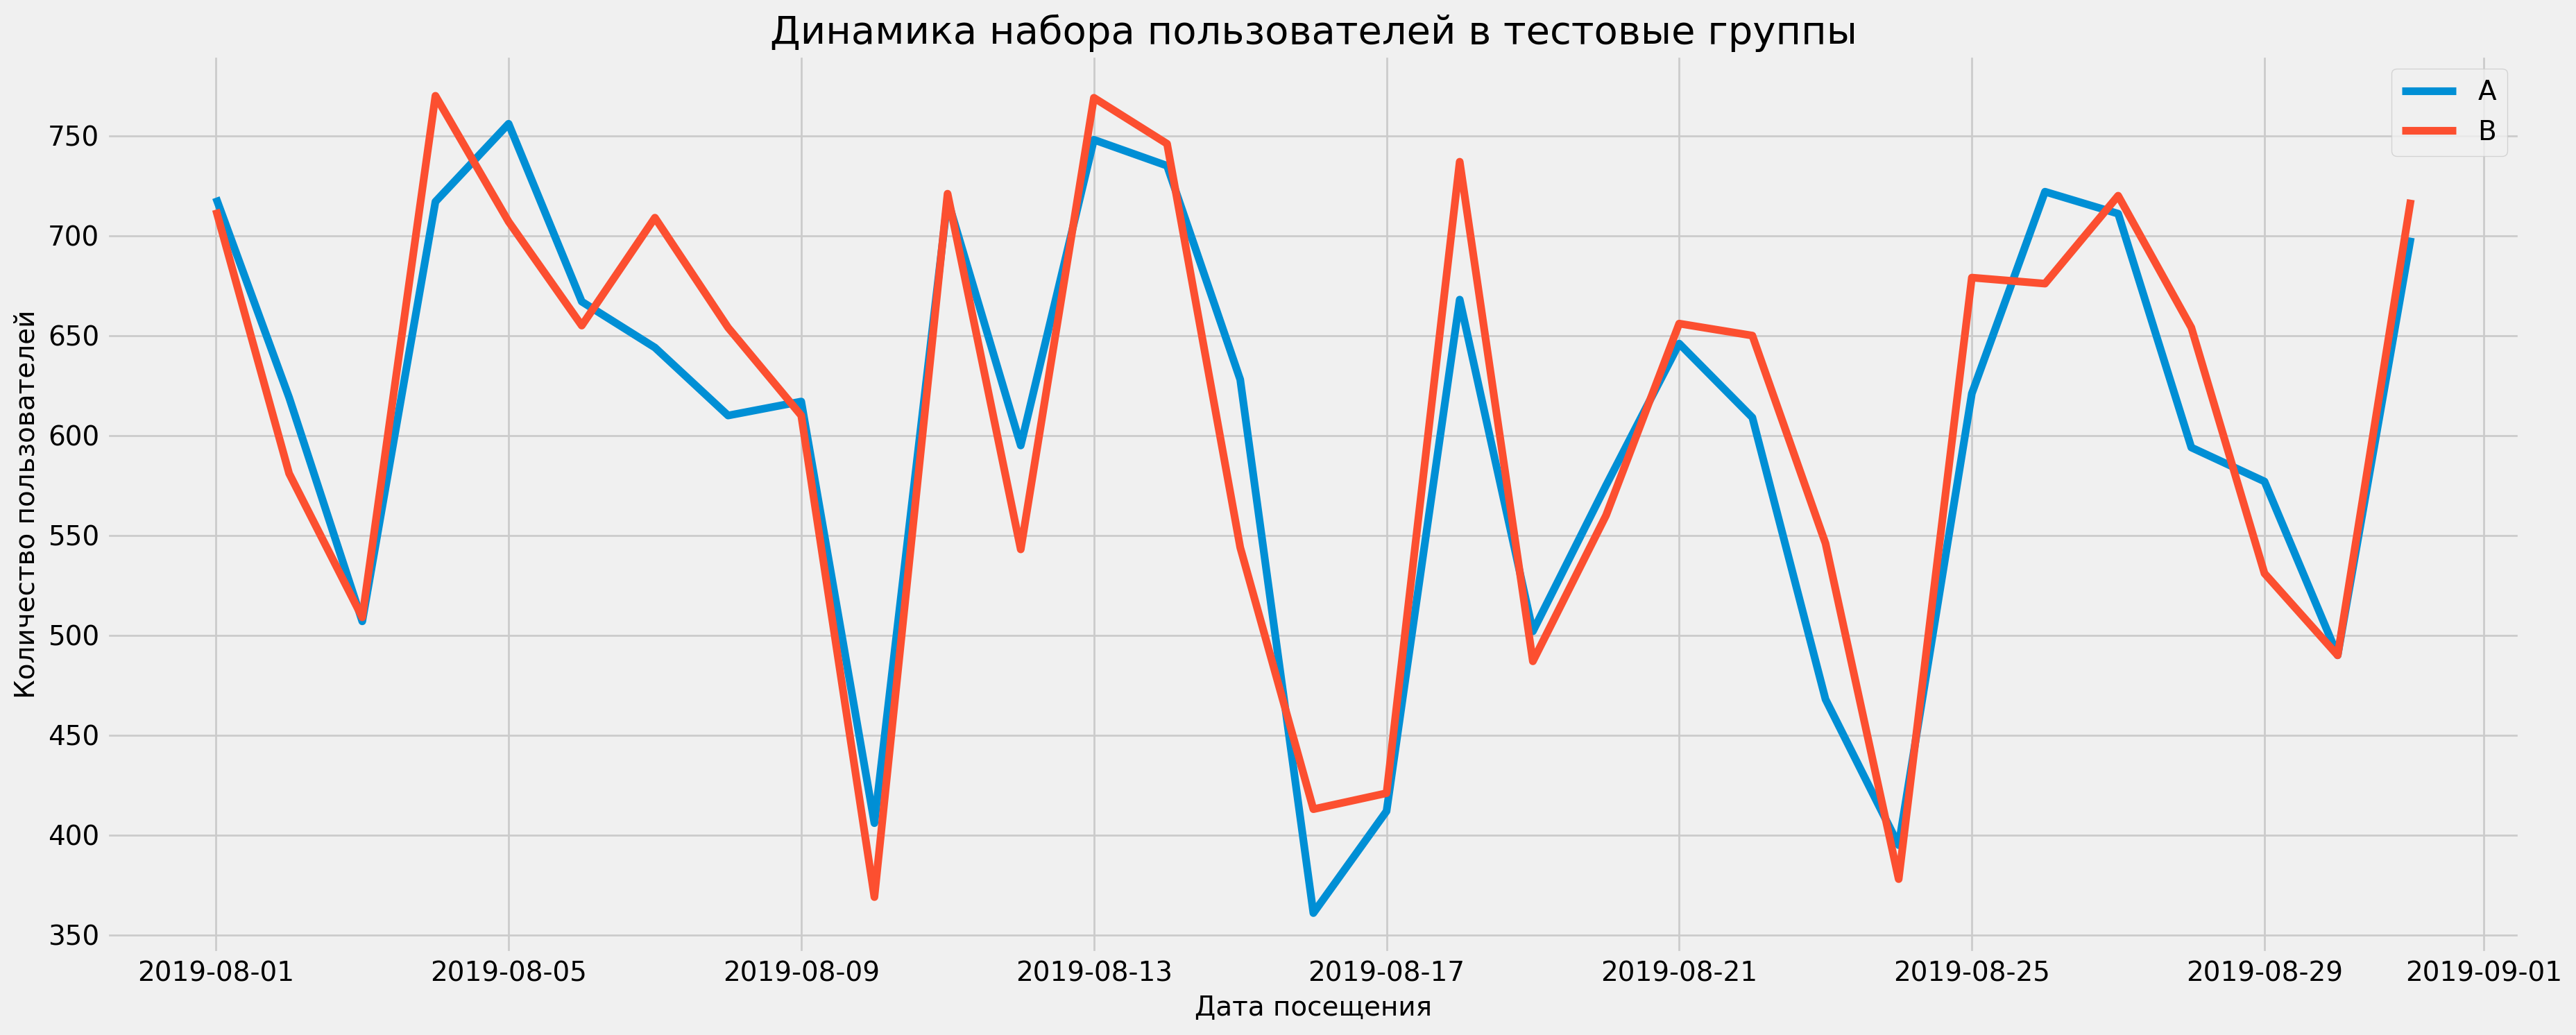

In [19]:
date_AB.plot(x='date',
             y=['A', 'B'])
plt.xlabel('Дата посещения')
plt.ylabel('Количество пользователей')
plt.title('Динамика набора пользователей в тестовые группы')
plt.show();

По графику динамики видно, что в группы шёл набор неравномерно: то в группу А попадало больше пользователей, то в группу В. Отметить какую-то цикличность нельзя, в течение всего времени тестирования количество пользователей варьировалось от 350 до 770.

### Пересечение пользователей

Проверим, совпадение пользователей в разных группах:

In [20]:
AB_merge = pd.merge(orders.query('group == "B"'), 
                    orders.query('group == "A"'), 
                    how ='inner', 
                    on ='visitor_id')['visitor_id'].nunique()
print('Количество пользователей, находящихся одновременно в двух группах: ', AB_merge)
print('Общее число уникальных пользователей в обеих группах: ', orders['visitor_id'].nunique())
print('Процент пересекающихся пользователей в двух группах', 
      '{0:.1%}'.format(AB_merge / orders['visitor_id'].nunique())) 

Количество пользователей, находящихся одновременно в двух группах:  58
Общее число уникальных пользователей в обеих группах:  1031
Процент пересекающихся пользователей в двух группах 5.6%


Можно отметить, что есть 58 пользователей, которые находятся сразу в обеих группах. Но при этом в датафрейме с посетителями мы не можем отделить одних пользователей от других, ведь информация по этой таблице только с указанием даты и количество посетителей каждой из групп в этот день. Таким образом, удалить этих пользователей из таблицы с заказами будет некорректным решением. К тому же 58 пользователей из 1031 общего числа пользователей в обеих группах составляет меньше 6%.

### Промежуточные выводы

- Было загружено 2 таблицы. 
- Ни в одной из таблиц не было пропусков данных, явных и неявных дубликатов. 
- Столбцы были переименованы согласно принятому стилю. 
- Столбцы с датами приведены к типу данных "дата" для дальнейшей работы с ними.
- Были обнаружены пересекающиеся пользователи в двух тестовых группах, их процент составил 5.6% от общего количества пользователей.
- Такие пользователи были оставлены в данных.

## Анализ A/B-теста

Прежде чем приступать к анализу А/В теста, необходимо собрать кумулятивные данные по группам.
Создадим датафрейм cumulativeData со столбцами: 
- `date` — дата;
- `group` — группа A/B-теста (A или B);
- `orders` — кумулятивное количество заказов на указанную дату в указанной группе;
- `buyers` — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе;
- `revenue` — кумулятивная выручка на указанную дату в указанной группе (средний чек);
- `visitors` — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.

In [21]:
# создаём массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates() 

In [22]:
# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups\
                   .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], 
                                                          orders['group'] == x['group'])]\
                                          .agg({'date' : 'max', 
                                                'group' : 'max', 
                                                'transaction_id' : 'nunique', 
                                                'visitor_id' : 'nunique', 
                                                'revenue' : 'sum'}), 
                                                axis=1)\
                   .sort_values(by=['date','group'])

In [23]:
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups\
                     .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], 
                                                               visitors['group'] == x['group'])]\
                                              .agg({'date' : 'max', 
                                                    'group' : 'max', 
                                                    'visitors' : 'sum'}), 
                                                  axis=1)\
                     .sort_values(by=['date','group'])

In [24]:
# объединяем кумулятивные данные в одной таблице и присваиваем её столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, 
                                        left_on=['date', 'group'],
                                        right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


In [25]:
cumulativeData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 0 to 61
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   orders    62 non-null     int64         
 3   buyers    62 non-null     int64         
 4   revenue   62 non-null     int64         
 5   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 3.4+ KB


Получилась таблица с кумулятивными данными из 5 столбцов и 62 записей. Проверим, была ли эта таблица создана корректно.

In [26]:
print('Минимальная дата созданного датафрейма: ', cumulativeData['date'].min())
print('Минимальная дата исходного датафрейма: ', orders['date'].min())
print('Максимальная дата созданного датафрейма: ', cumulativeData['date'].max())
print('Максимальная дата исходного датафрейма: ', orders['date'].max())

Минимальная дата созданного датафрейма:  2019-08-01 00:00:00
Минимальная дата исходного датафрейма:  2019-08-01 00:00:00
Максимальная дата созданного датафрейма:  2019-08-31 00:00:00
Максимальная дата исходного датафрейма:  2019-08-31 00:00:00


Минимальная и максимальная даты в исходном и созданном датайреймах совпадают. Теперь можно переходить к анализу данных.

### Кумулятивная выручка по группам

Построим графики кумулятивной выручки по дням и группам A/B тестирования.

In [27]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData.query('group == "A"')[['date','revenue', 'orders']]
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData.query('group == "B"')[['date','revenue', 'orders']]

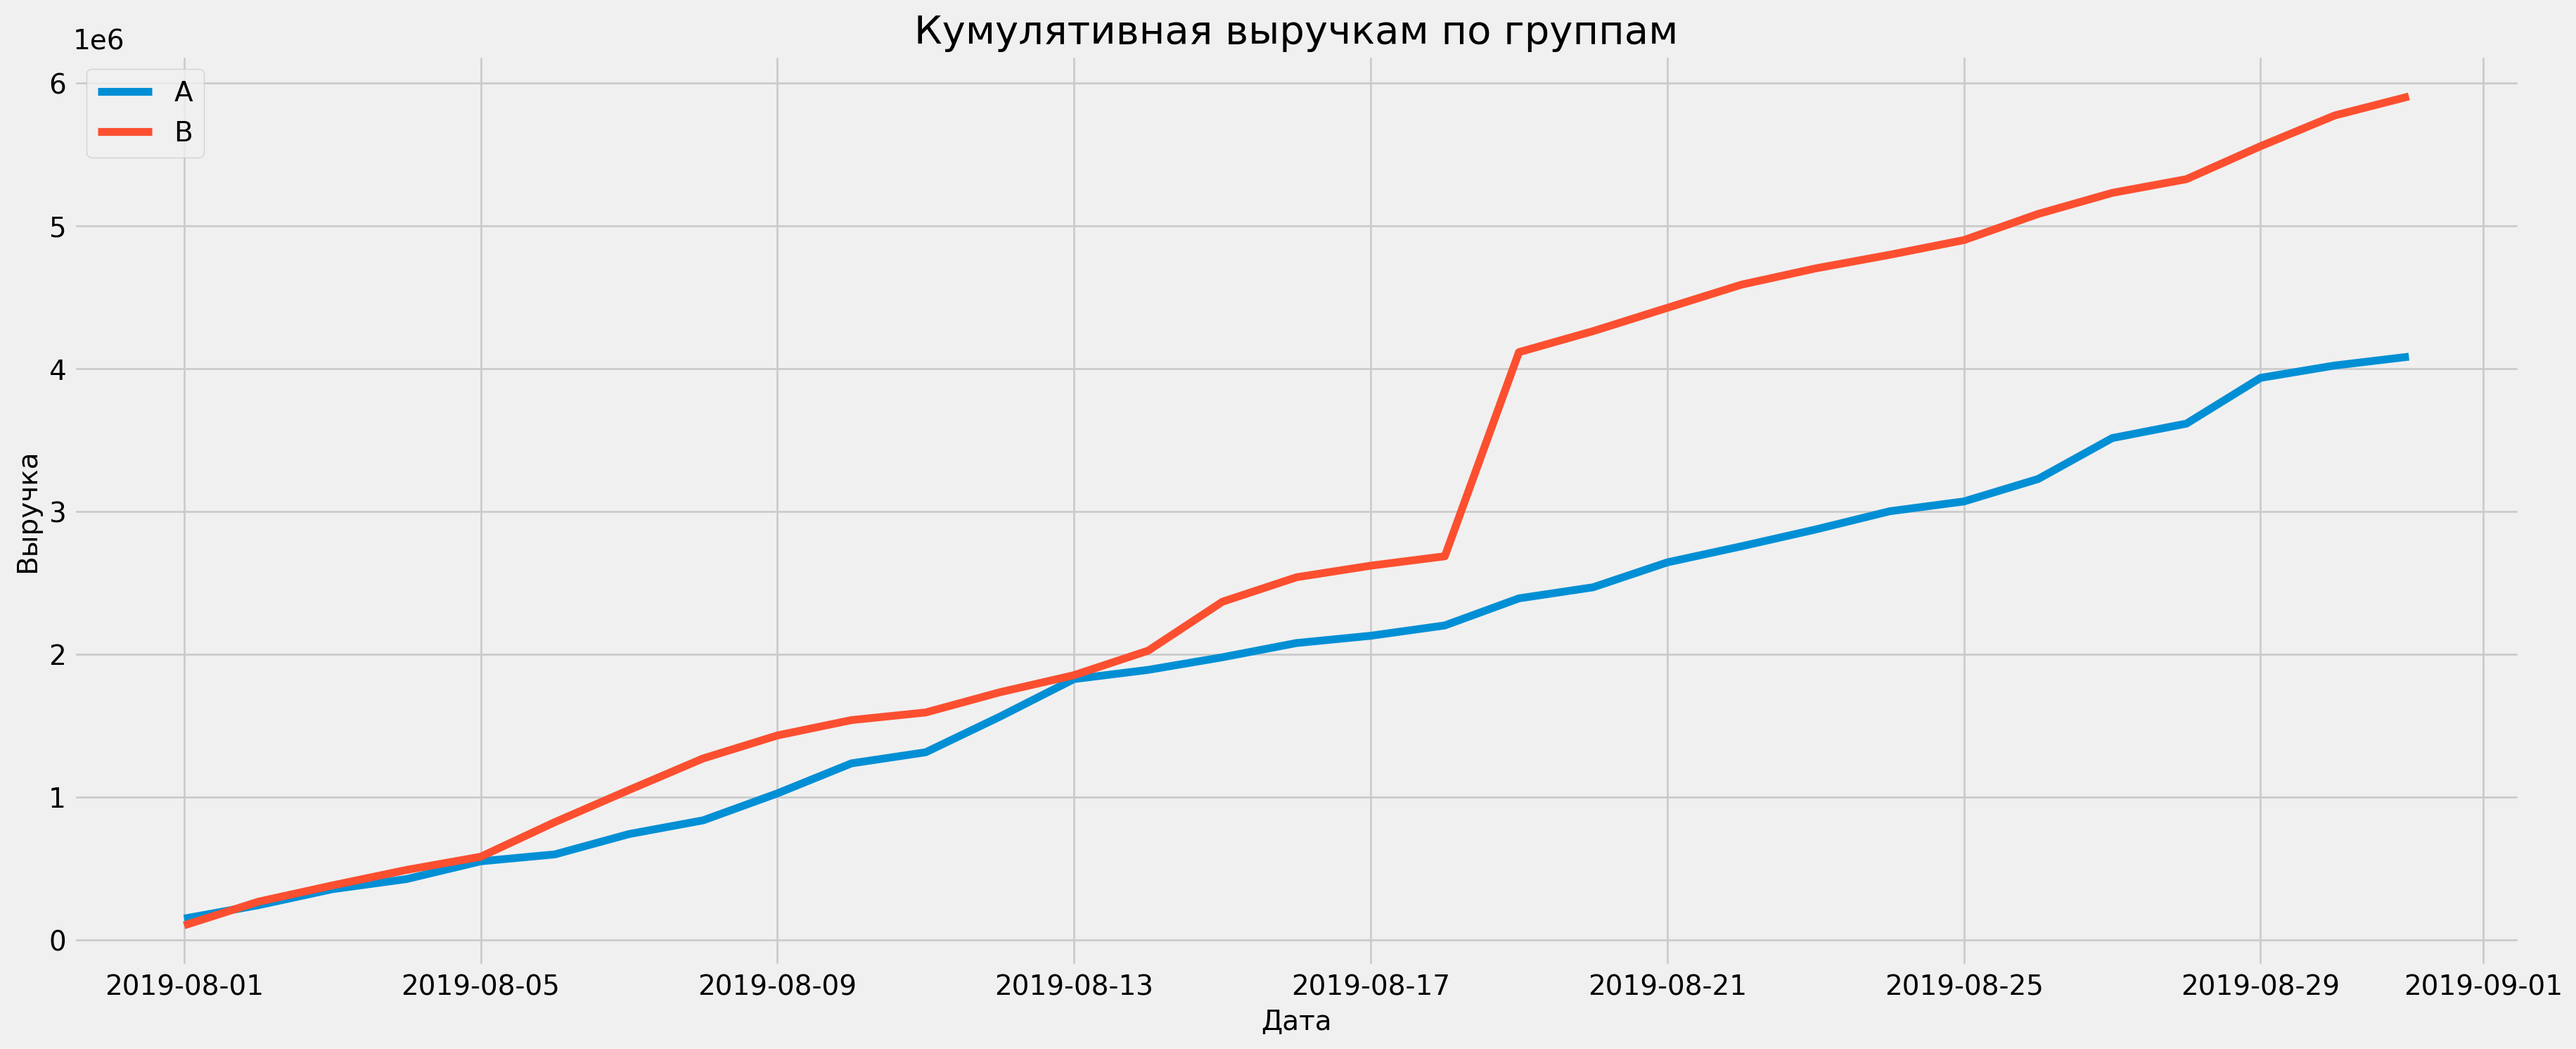

In [28]:
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.title('Кумулятивная выручкам по группам')
plt.legend() 
plt.show();

Выручка почти равномерно увеличивается в течение всего теста для группы А, а для группы В с 17 августа - почти в середине теста, произошёл скачок и группа В стала однозначно лидировать по выручке весь остаток теста. Это может означать, что либо в выборке появились слишком дорогие заказы, либо были всплески количества заказов. Необходимо будет проверить это в дальнейшем.

### Кумулятивный средний чек по группам

Построим графики среднего чека по группам.

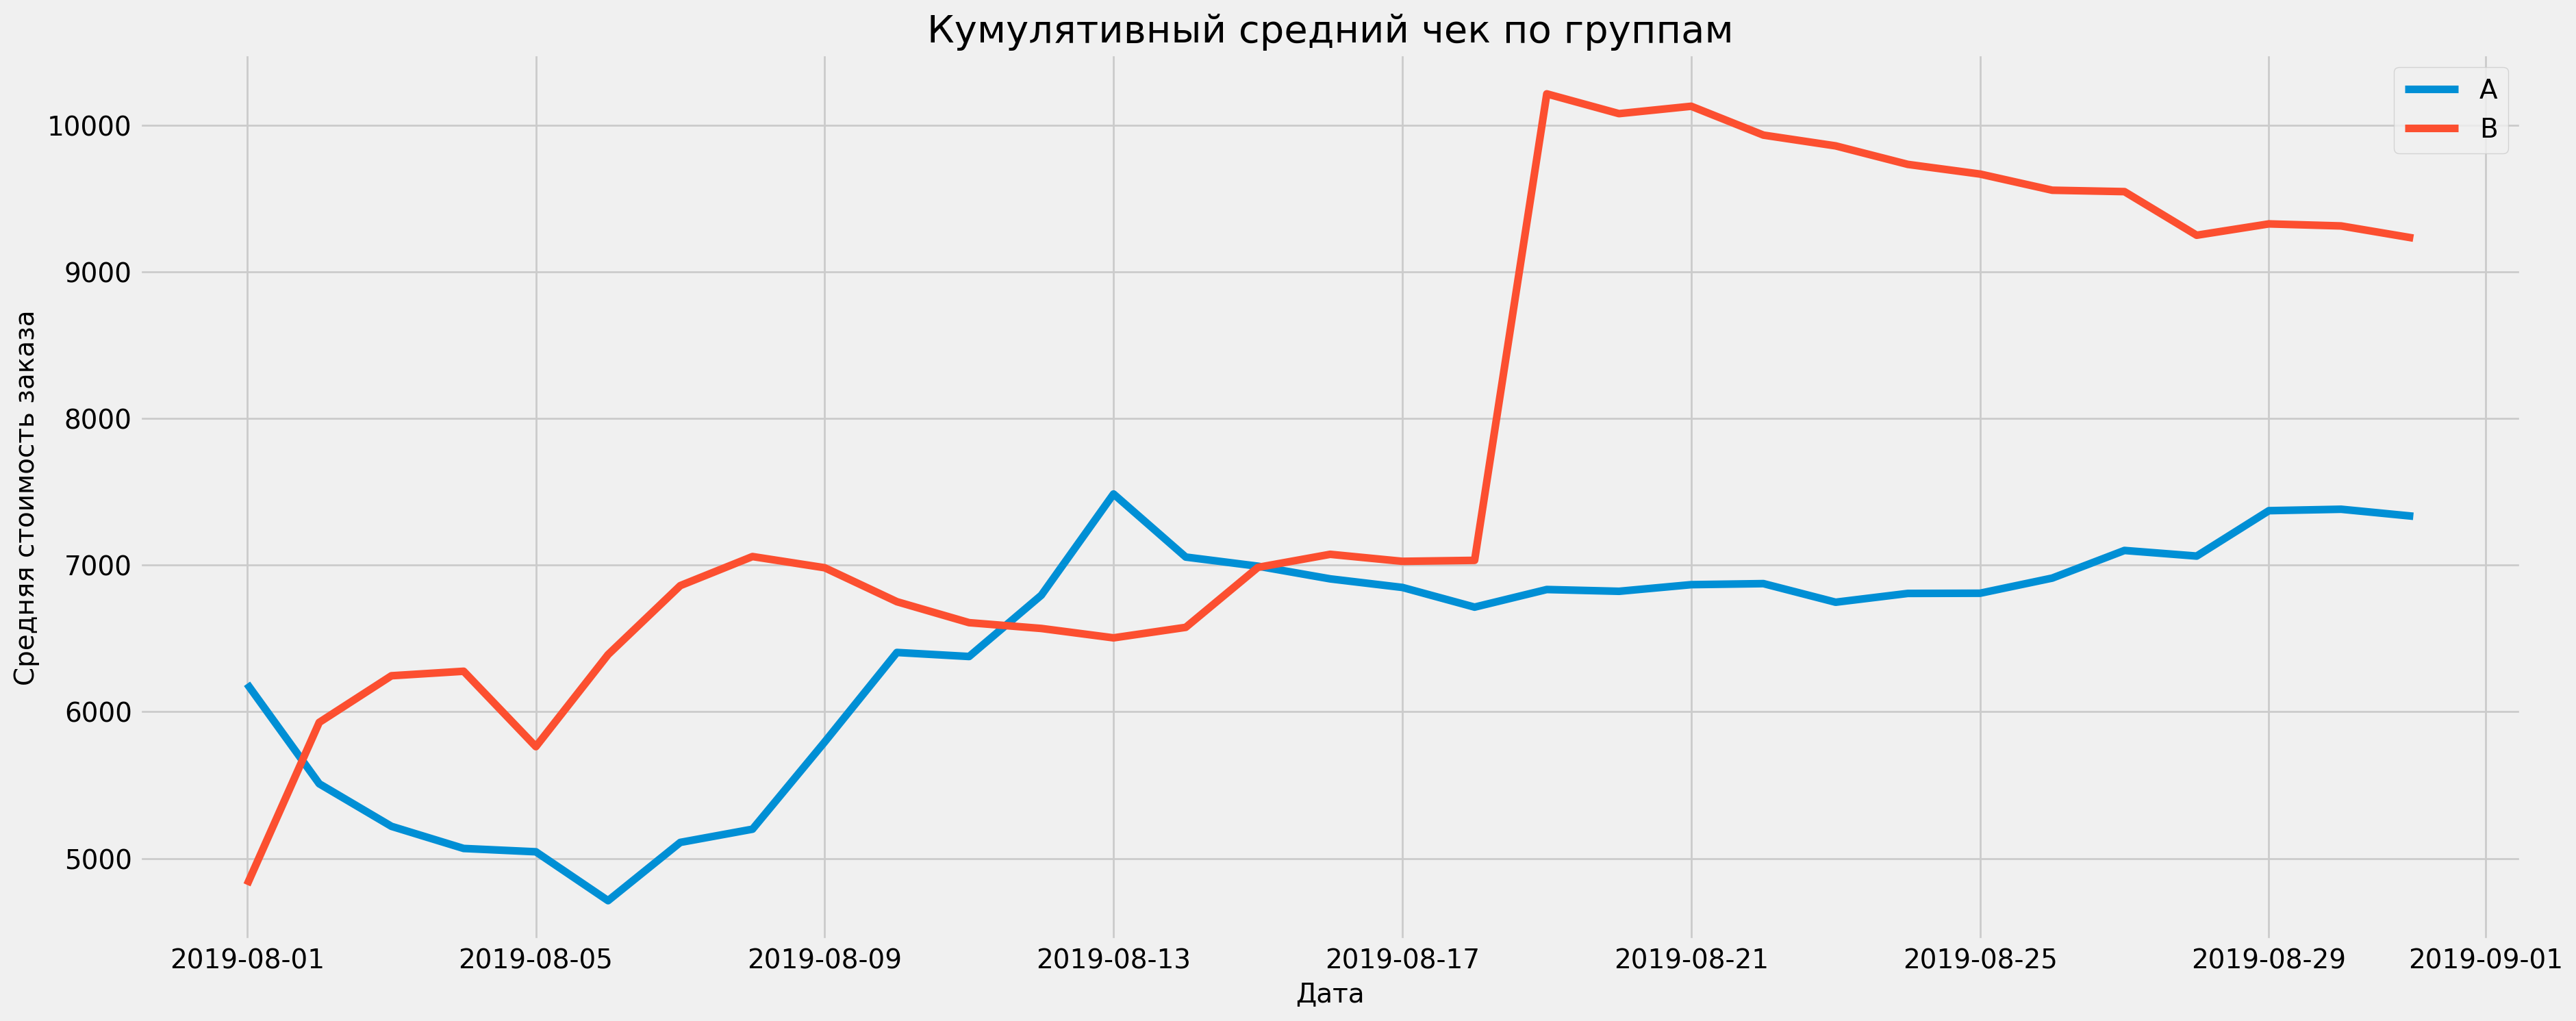

In [29]:
# Строим график среднего чека группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')

# Строим график среднего чека группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.xlabel('Дата')
plt.ylabel('Средняя стоимость заказа')
plt.title('Кумулятивный средний чек по группам')
plt.legend()
plt.show();

Кумулятивное значение среднего чека весьма колеблется на протяжении всего теста. Причём, к концу теста после резкого скачка для группы В он начал снижаться, а для группы А под конец теста немного растёт. Возможно, в группу В в середине теста попали крупные заказы, так как произошёл резкий скачок на графике, тогда ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне. Возможно, потребуется дополнительный анализ выбросов, которые могут искажать результаты.

### Относительное изменение кумулятивного среднего чека группы B к группе A

Построим график относительного различия для среднего чека.

In [30]:
# соберём данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, 
                                                   left_on='date', 
                                                   right_on='date', 
                                                   how='left', 
                                                   suffixes=['A', 'B'])

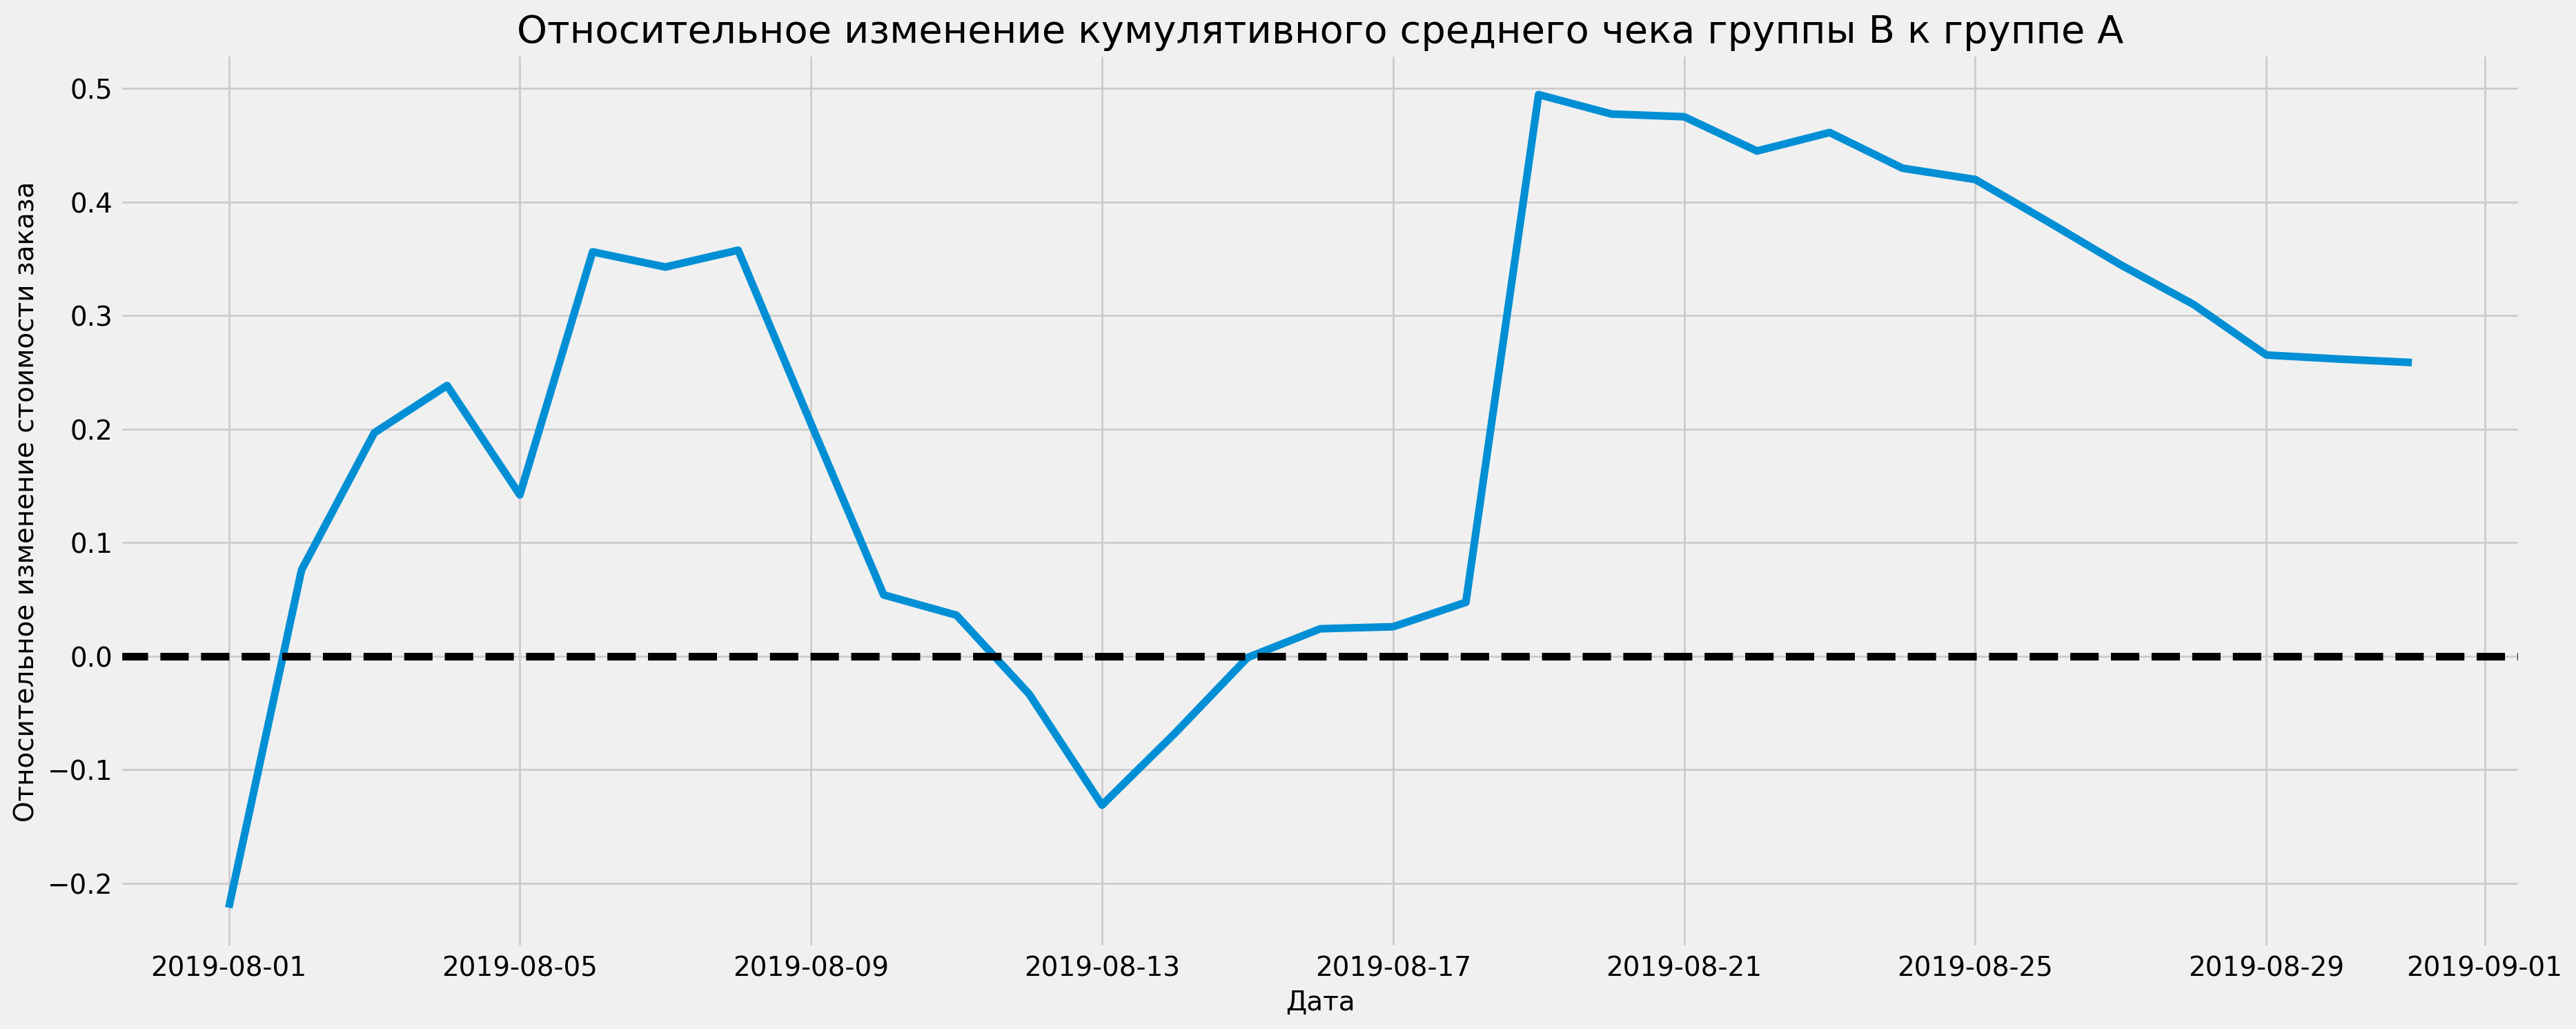

In [31]:
# график отношения средних чеков
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])\
         /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])\
         -1)

# добавим ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.xlabel('Дата')
plt.ylabel('Относительное изменение стоимости заказа')
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.show();

Можно отметить, что в нескольких точках график различия между группами резко «скачет». Вполне вероятно именно в эти дни и были совершены какие-то аномальные заказы.

### Кумулятивное среднее количество заказов на посетителя по группам

Проанализируем график кумулятивного среднего количества заказов на посетителя для двух групп.

In [32]:
# считаем кумулятивное среднее количество заказов на посетителя
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

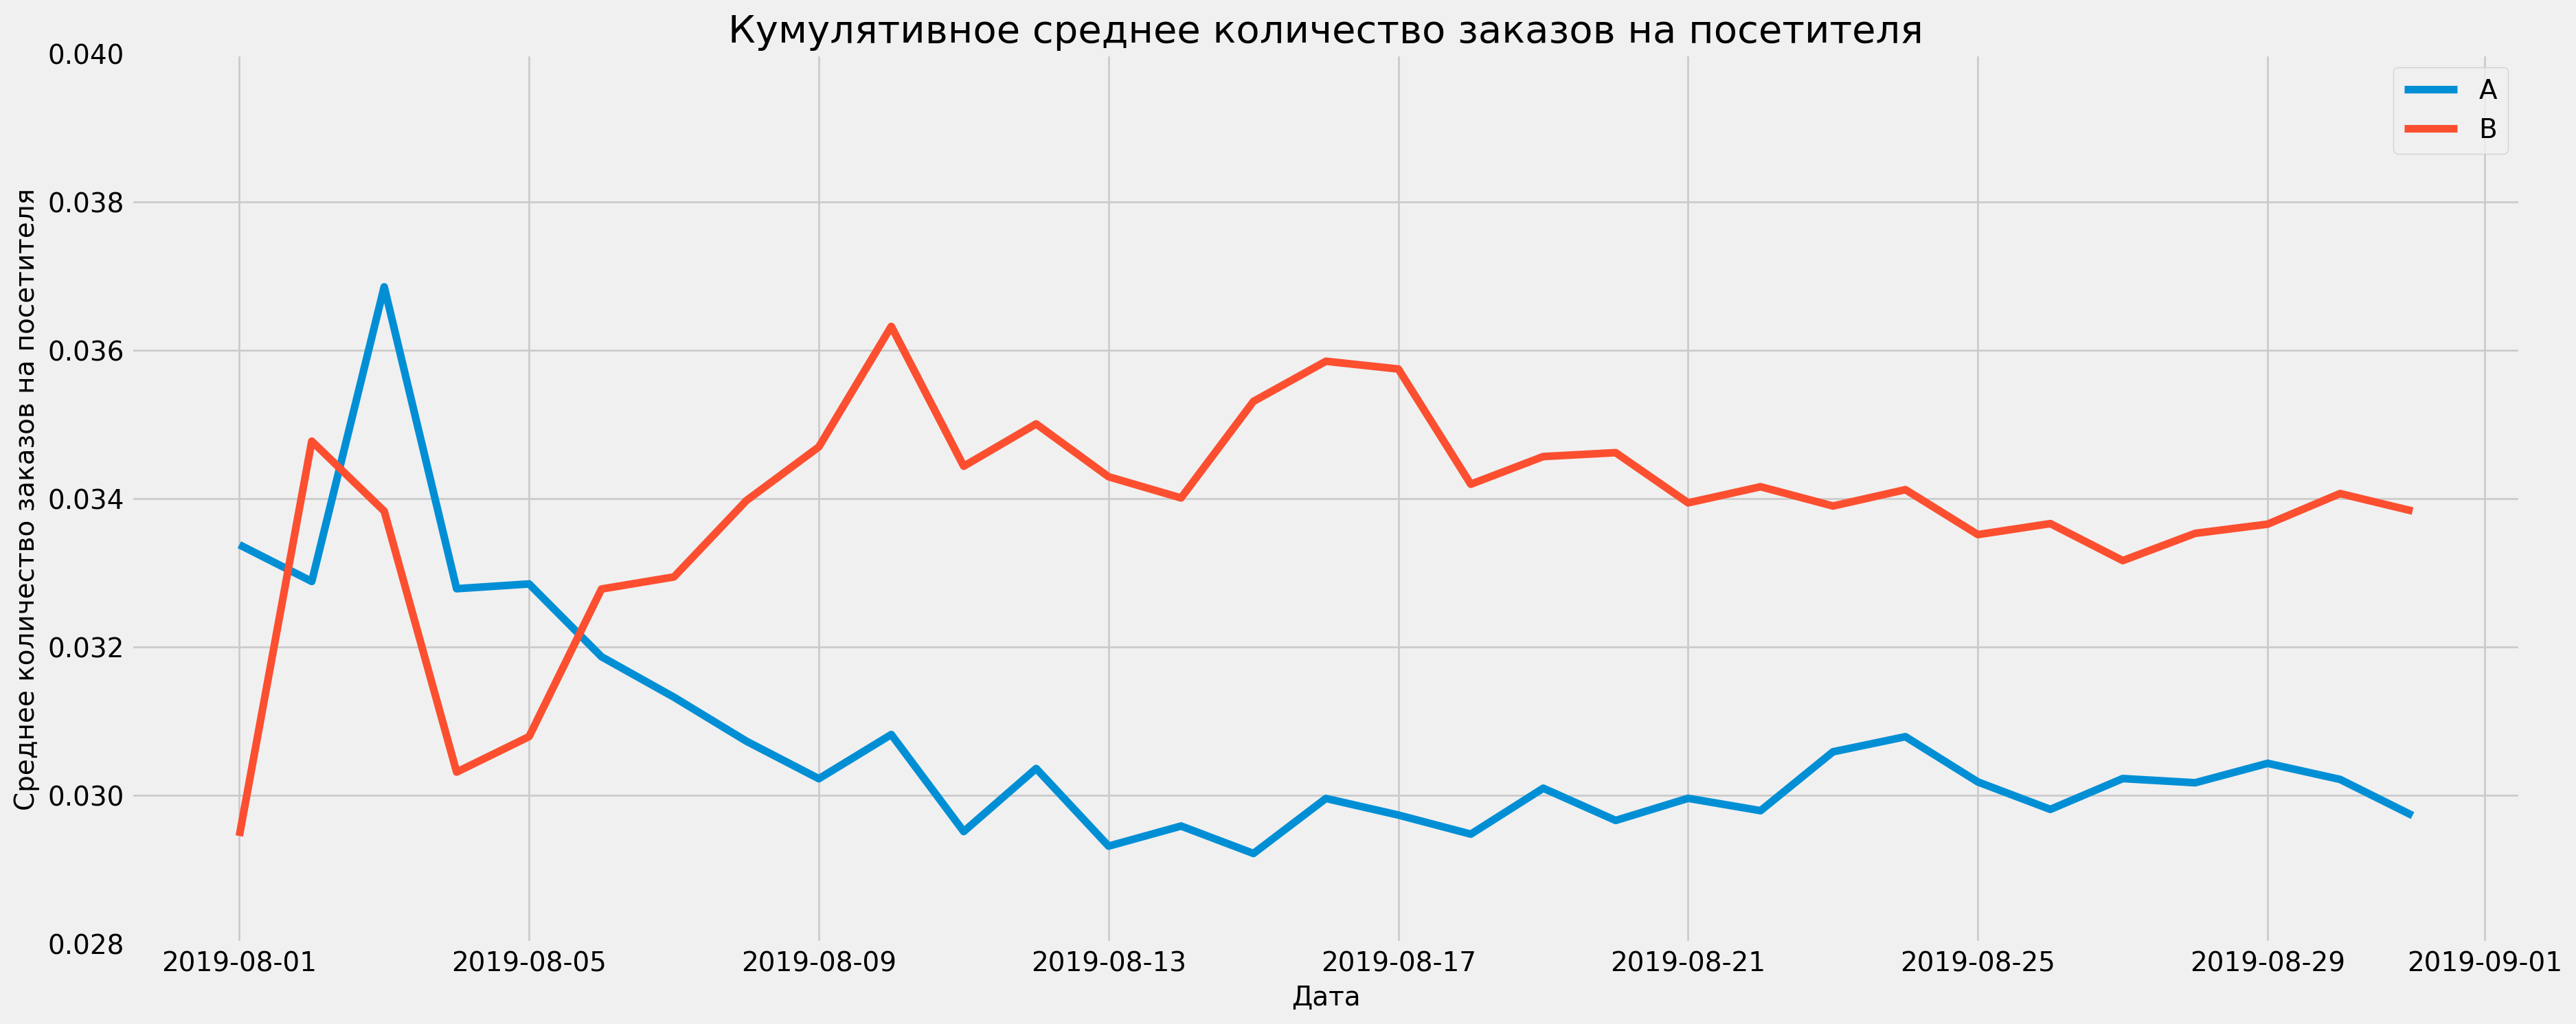

In [33]:
# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

# задаем масштаб осей
plt.yticks(ticks=np.arange(0.028, 0.041, 0.002))

plt.legend()
plt.xlabel('Дата')
plt.ylabel('Среднее количество заказов на посетителя')
plt.title('Кумулятивное среднее количество заказов на посетителя')
plt.show();

Поначалу для обеих групп значение среднего числа заказов на одного посетителя возрастает, затем немного падает, а дальше для группы В это значение возросло и вышло во второй половине теста на ровную планку. Для группы А среднее число заказов на посетителя снизилось, но тоже зафиксировалось до конца теста.

### Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A

Построим график относительного различия кумулятивного среднего количества заказов на посетителя для разных групп.

In [34]:
# соберём данные в одном датафрейме
mergedCumulativeConversions = cumulativeDataA[['date','conversion']]\
                              .merge(cumulativeDataB[['date','conversion']], 
                                     left_on='date', 
                                     right_on='date', 
                                     how='left', 
                                     suffixes=['A', 'B'])

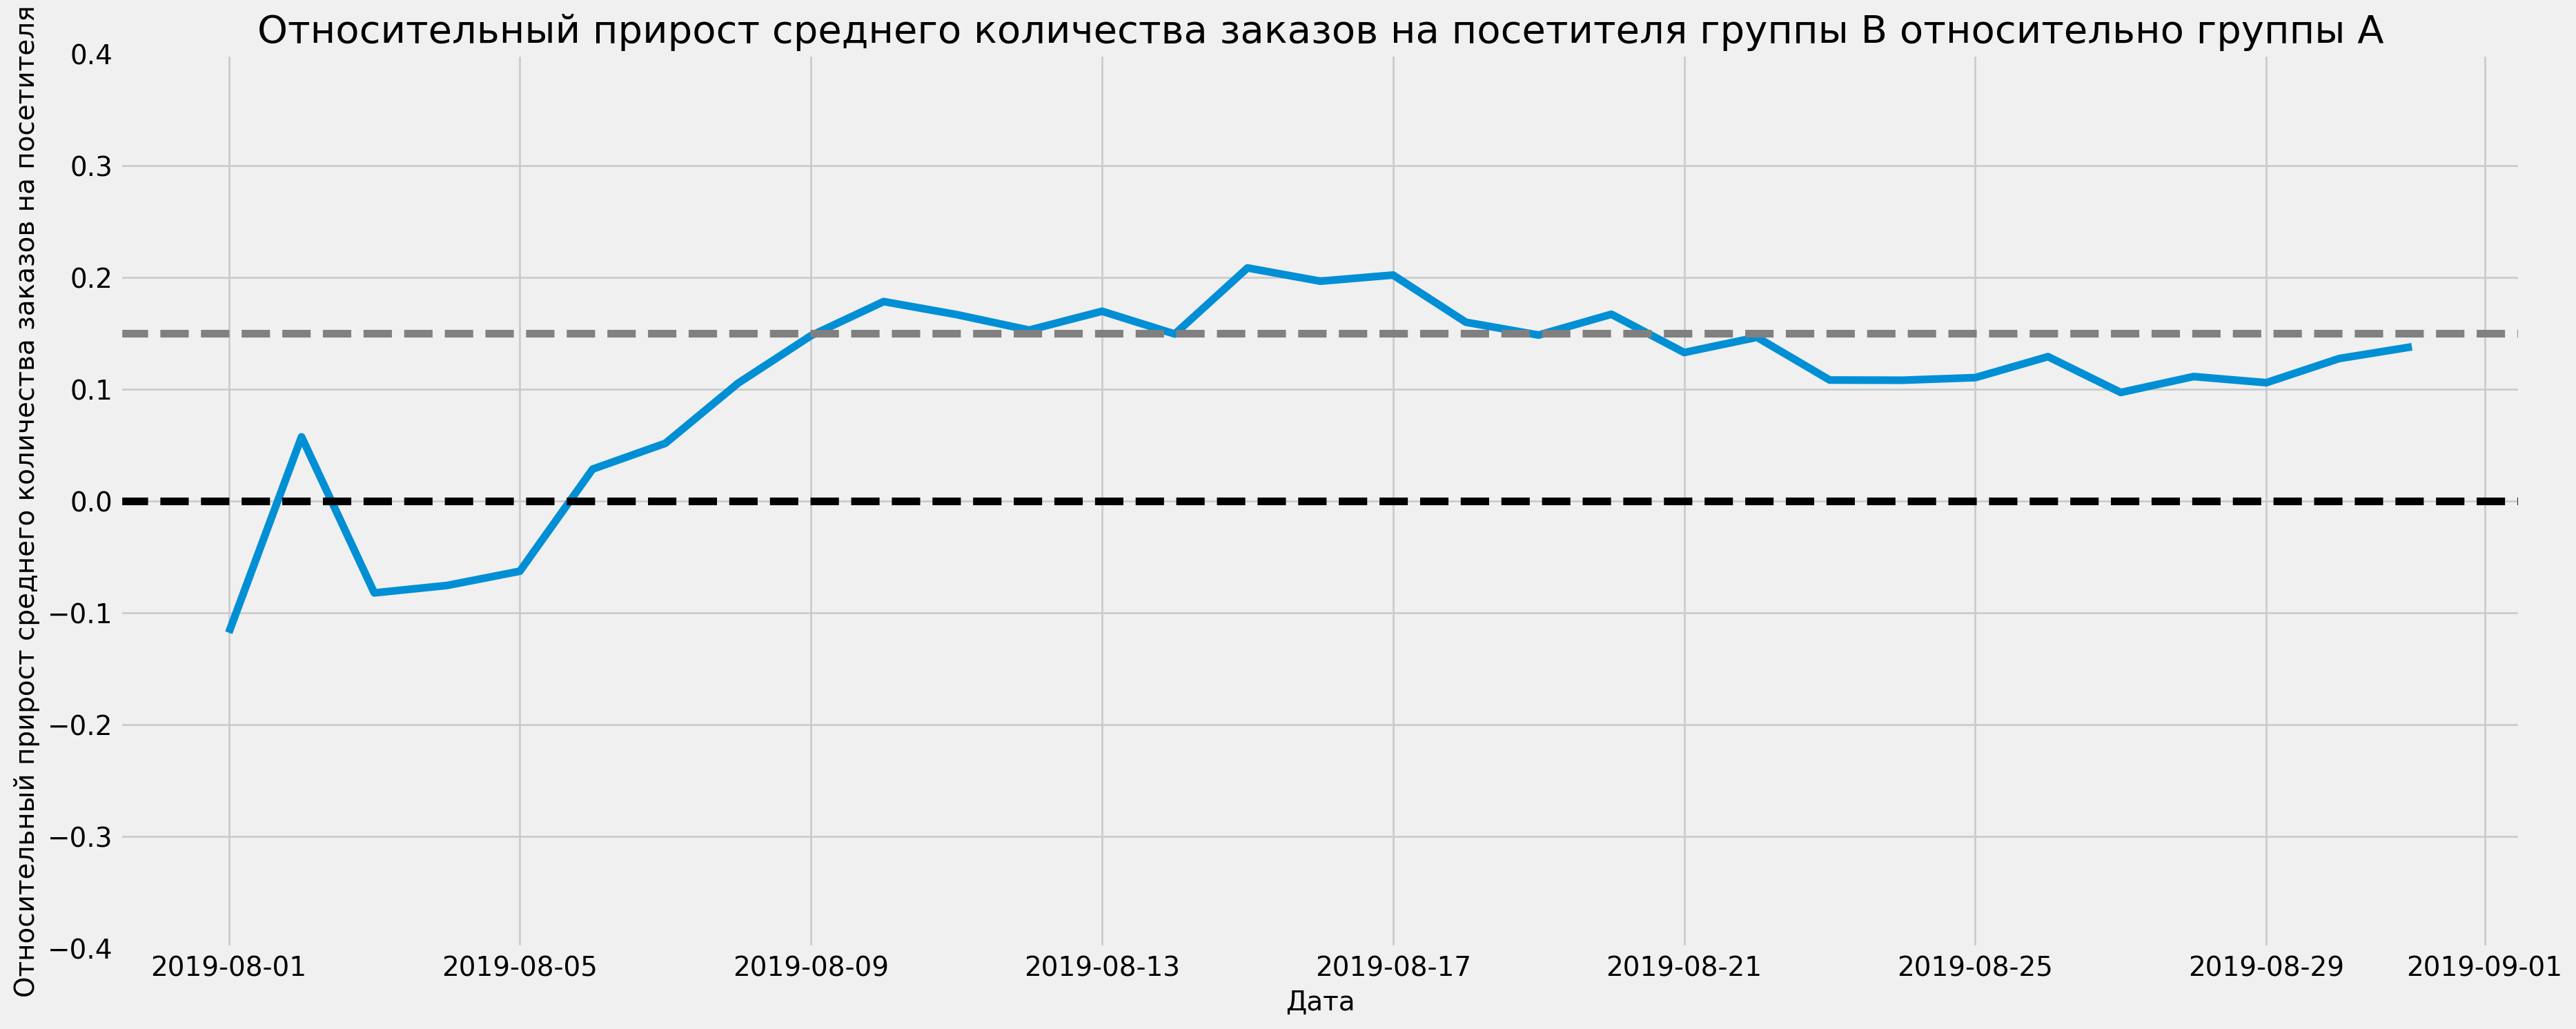

In [35]:
plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, 
         label="Относительный прирост среднего количества заказов на посетителя группы B относительно группы A")

# задаём масштаб осей
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')

# задаём масштаб осей
plt.yticks(ticks=np.arange(-0.4, 0.41, 0.1))
plt.xlabel('Дата')
plt.ylabel('Относительный прирост среднего количества заказов на посетителя')
plt.title('Относительный прирост среднего количества заказов на посетителя группы В относительно группы А')
plt.show();

Почти с самого начала теста группа В лидирует по среднему количеству заказов на посетителя и растёт в значениях, с середины теста происходит небольшая просадка в значениях, но к концу разница установилась около прироста в 15% относительно группы А.

### Количество заказов по пользователям

Построим точечную диаграмму числа заказов на одного пользователя.

In [36]:
ordersByUsers = orders.groupby('visitor_id', as_index=False)\
                      .agg(orders = ('transaction_id', 'nunique'),
                           revenue = ('revenue', 'sum'))
ordersByUsers.sort_values(by='orders', ascending=False).head()

,visitor_id,orders,revenue
1023,4256040402,11,176490
591,2458001652,11,62098
569,2378935119,9,142939
487,2038680547,8,15470
44,199603092,5,23180


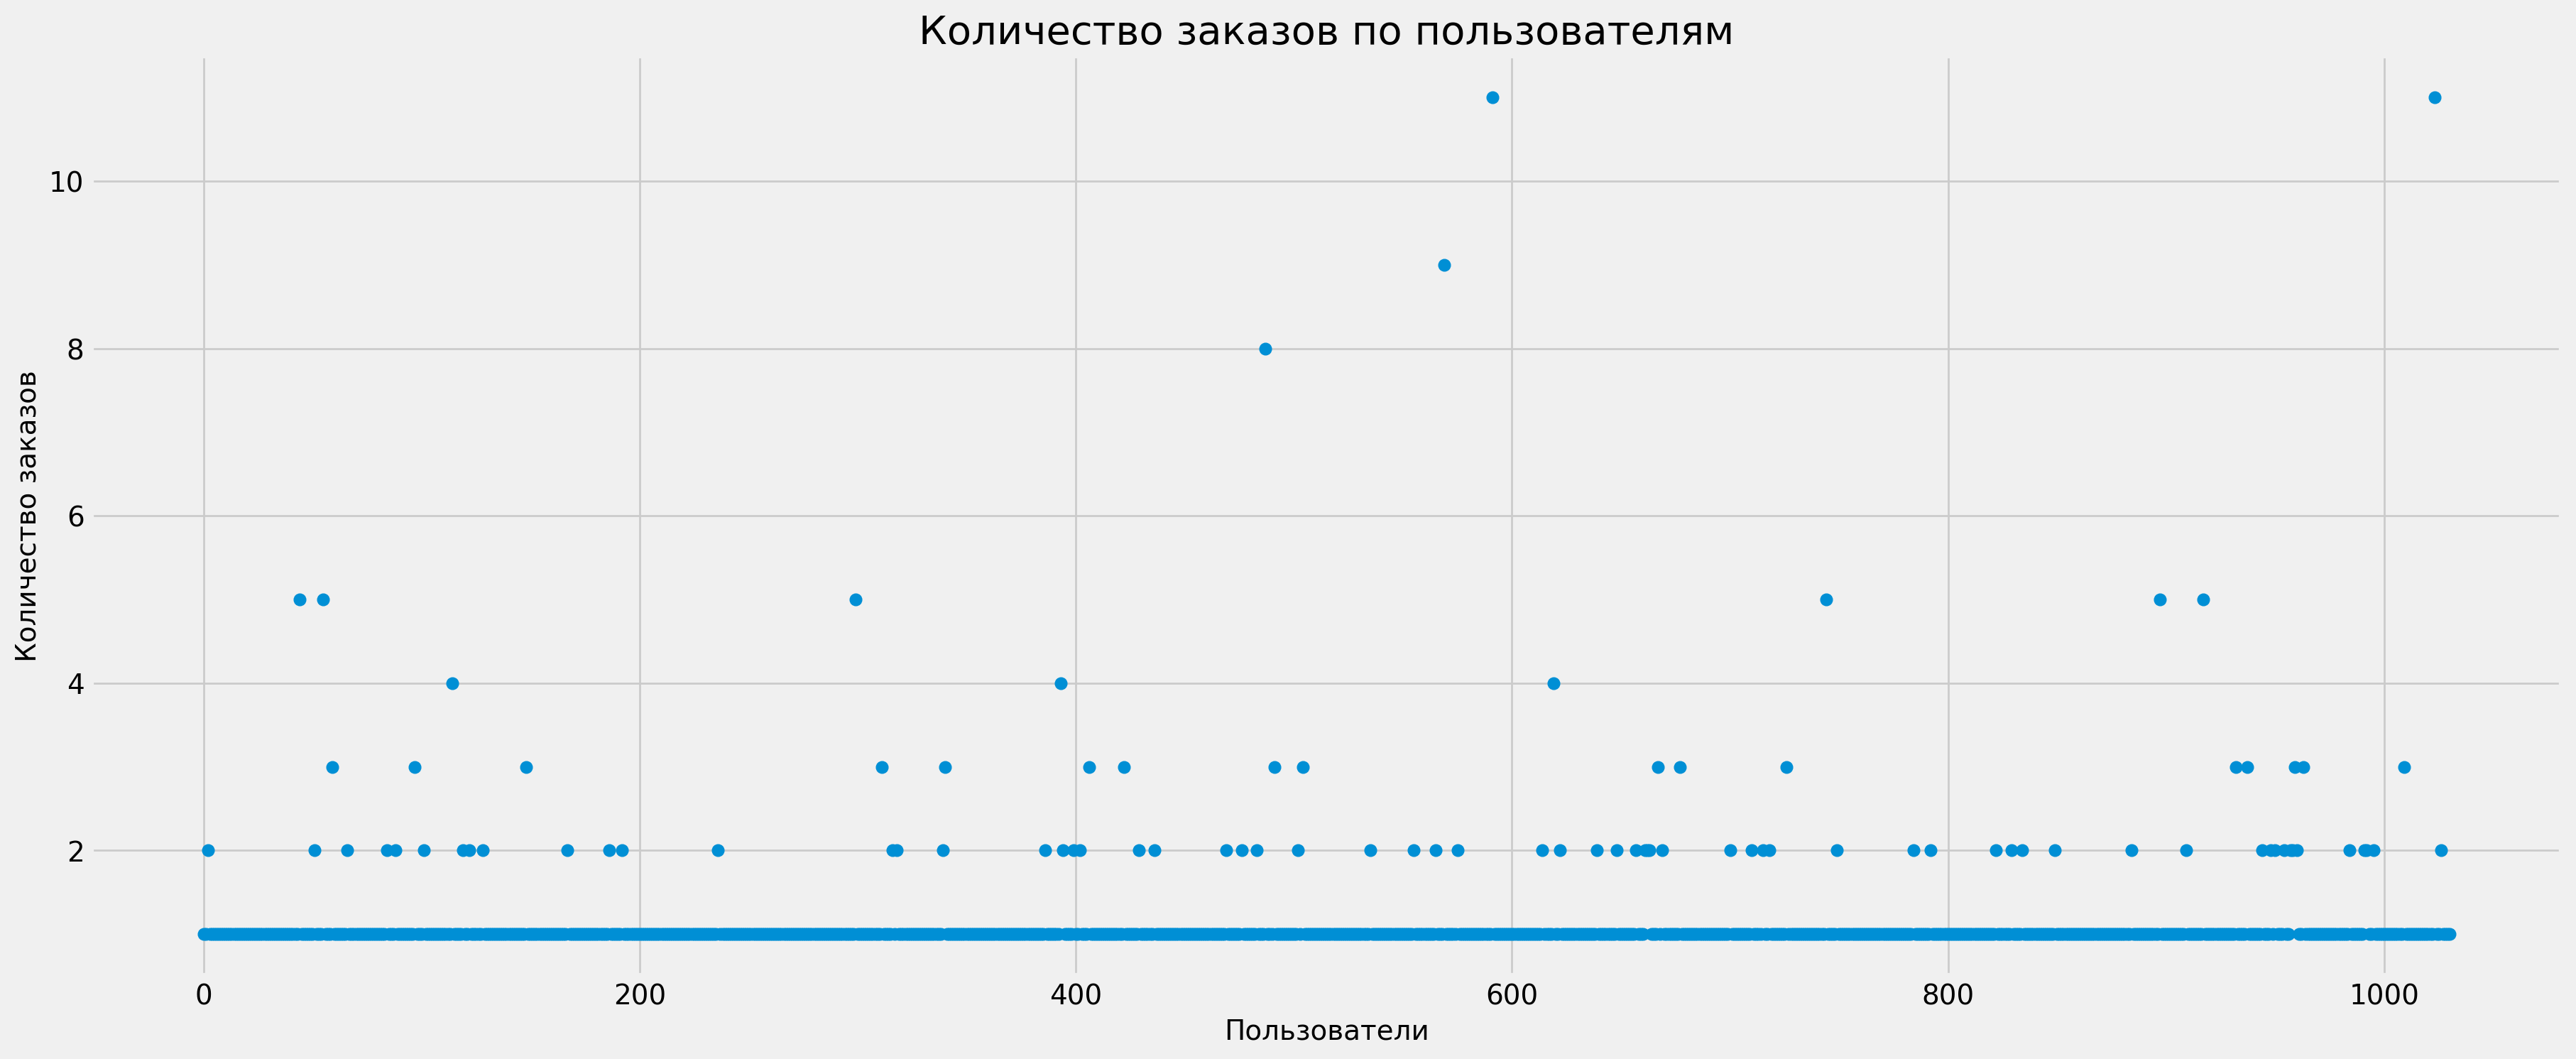

In [37]:
# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])

plt.xlabel('Пользователи')
plt.ylabel('Количество заказов')
plt.title('Количество заказов по пользователям')
plt.show();

Большинство пользователей за время теста сделали только 1 заказ, меньшее количество сделали 2 заказа. А 4 и более заказов выглядят как единичные выбросы, особенно 8-11 заказов (рассматриваемый промежуток времени 1 месяц, за такой срок ожидается увидеть всего 1-2 заказа от "обычного" пользователя, не более).

### Граница для определения количества аномальных заказов

Так как принято отсеивать от 1% до 5% наблюдений с крайними значениями, то посмотрим на значения перцентилей начиная с 95.

In [38]:
print('95 и 99 перцентиль для количества заказов на одного пользователя: ', 
      np.percentile(ordersByUsers['orders'], 95), ', ',
      np.percentile(ordersByUsers['orders'], 99))

95 и 99 перцентиль для количества заказов на одного пользователя:  2.0 ,  4.0


Не более 5% больше 2х заказов от одного пользователя, и не более 1% превышает значение в 4 заказа. Пользователи, совершившие много заказов, влияют на числитель формулы среднего количества заказов на посетителя. Скорее всего, их поведение отличается от нормального. Выберем 2 заказа на одного пользователя за верхнюю границу числа заказов.

### Стоимость заказов по пользователям

Построим точечную диаграмму стоимости заказов на одного пользователя.

In [39]:
ordersByUsers.sort_values(by='revenue', ascending=False).head()

,visitor_id,orders,revenue
463,1920142716,1,1294500
503,2108080724,1,202740
1023,4256040402,11,176490
1026,4266935830,2,157980
569,2378935119,9,142939


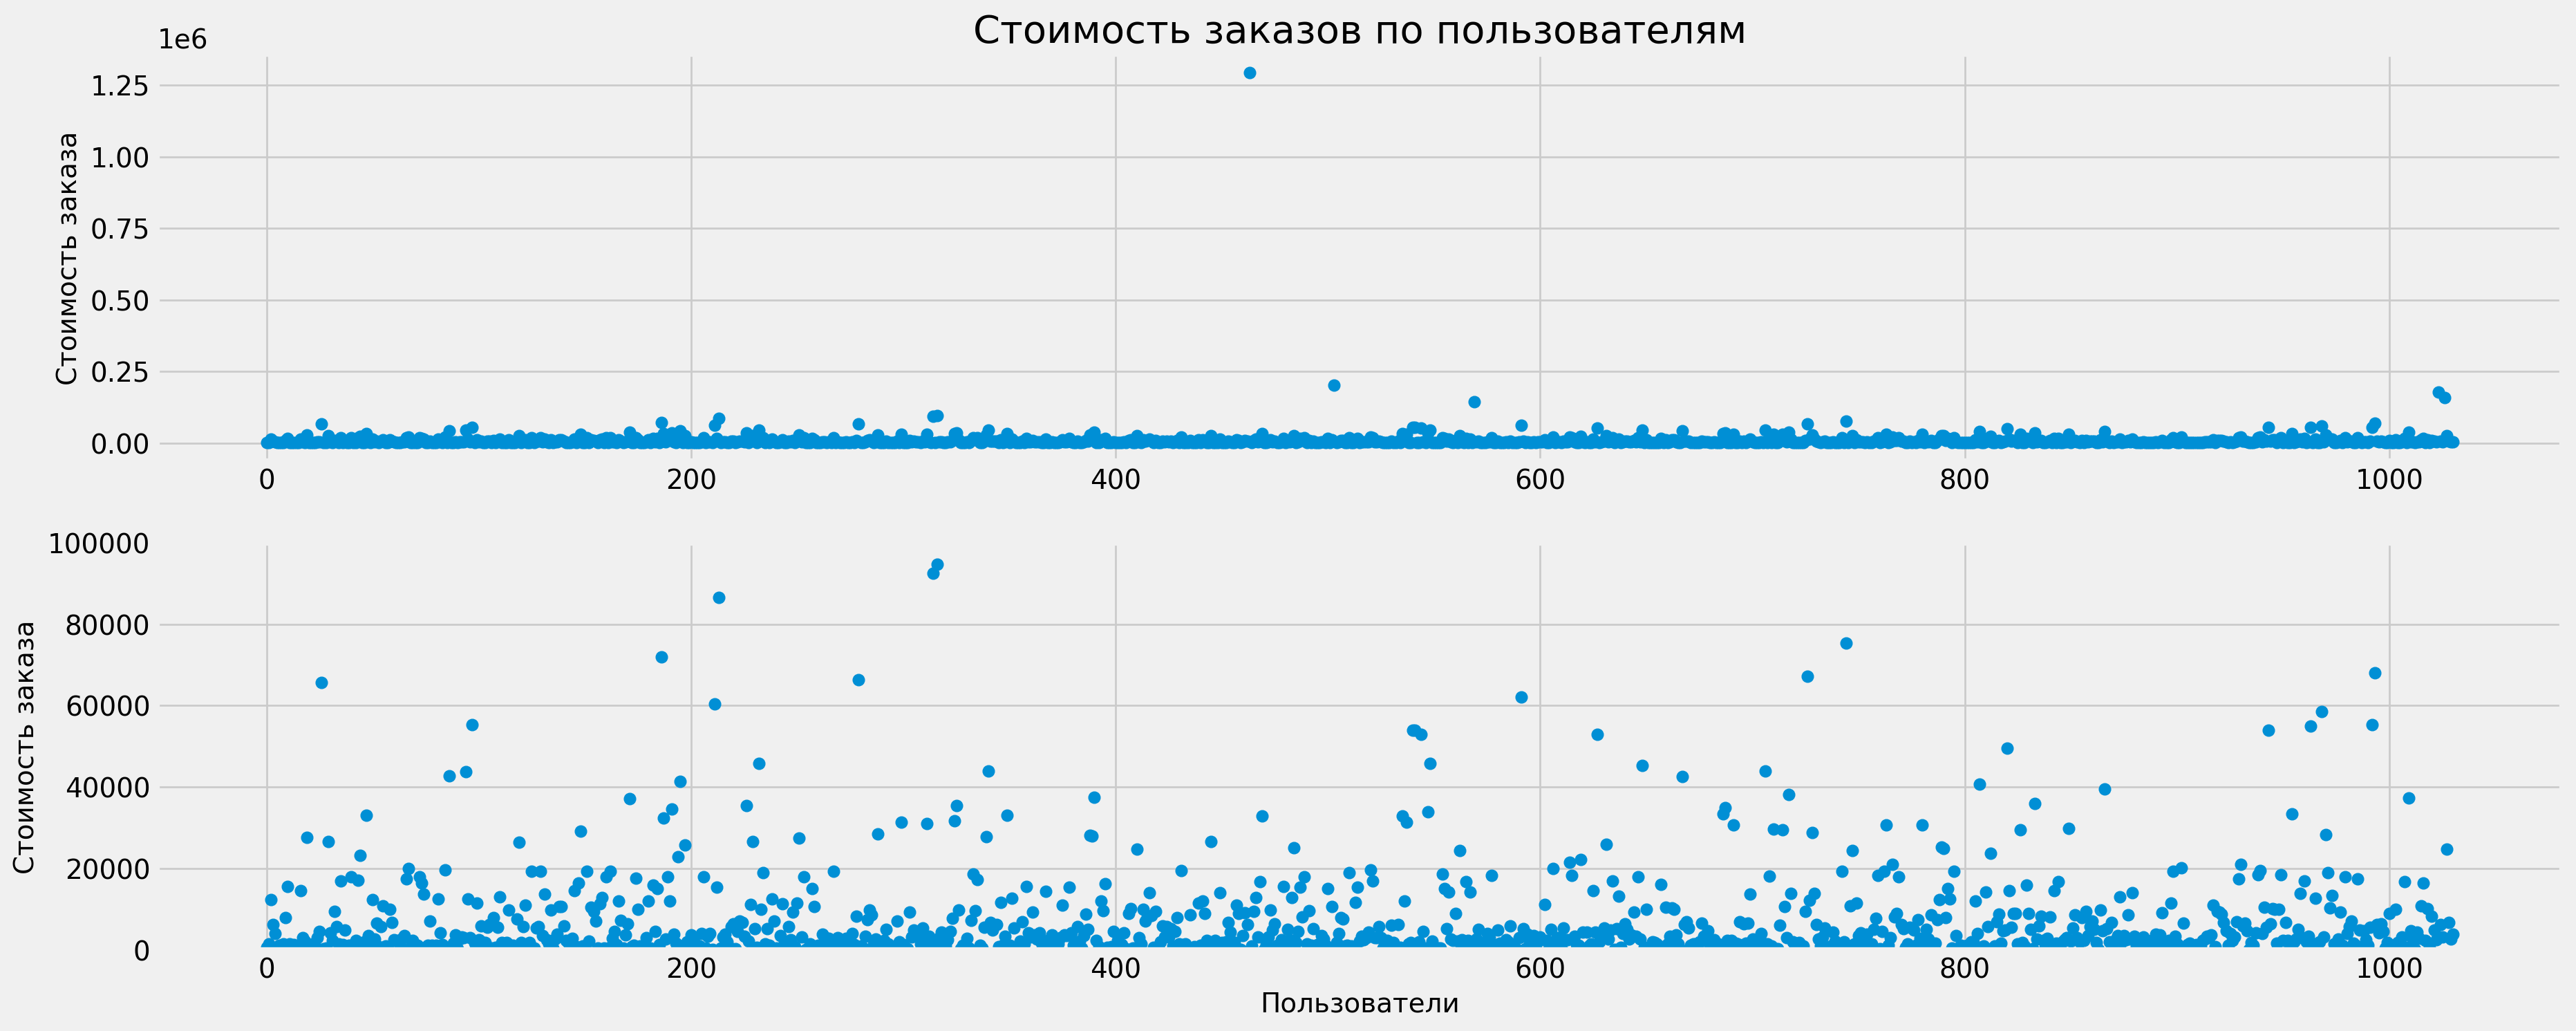

In [40]:
# задаём размер сетки для графиков
fig, (ax1, ax2) = plt.subplots(2, figsize=(20, 8))

# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))

# первый график — стоимость заказов по пользователям полный
ax1.scatter(x_values, ordersByUsers['revenue'])
ax1.set(ylabel = 'Стоимость заказа', title='Стоимость заказов по пользователям')

# второй график — стоимость заказов по пользователям ограничен по у
ax2.scatter(x_values, ordersByUsers['revenue'])
ax2.set(xlabel = 'Пользователи', ylabel = 'Стоимость заказа', ylim = [-1e2, 1e5])

plt.show();

Сумма выше 40 тыс на пользователя выбивается среди среднего чека на пользователя. А сумма в 1 млн 200 тыс за 1 заказ выглядит весьма нереалистичной. Однозначно такие аномальные выбросы будут сильно изменять результаты А/В теста, в зависимости от того, в какую группу они попадут. Проверим оцененую на глаз сумму среднего чека через подсчёт перцентилей.

### Граница для определения суммы аномальных заказов

In [41]:
print('95 и 99 перцентиль для суммы заказа на одного пользователя: ', 
      np.percentile(ordersByUsers['revenue'], 95), ', ',
      "{0:.1f}".format(np.percentile(ordersByUsers['revenue'], 99)))

95 и 99 перцентиль для суммы заказа на одного пользователя:  32899.5 ,  67750.0


Не более 5% больше *32 899* от одного пользователя на заказ, и не более 1% превышает значение в *67 750*. Поведение пользователей, которые потратили больше на свои покупки в интернет-магазине за месяц, отличается от нормального. Выберем 33 тыс на одного пользователя за верхнюю границу стоимости заказа.

### Подготовка данных для подсчёта статистической значимости между группами

Подготовим данные к анализу: разъединим пользователей по группам.

In [42]:
# Выделим кумулятивные параметры в выбранную дату в группе А
cumulativeDataA = cumulativeData.query('group == "A"')[['date', 'orders', 'revenue', 'visitors']]
cumulativeDataA.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA', 'visitorsCummulativeA']

# Выделим кумулятивные параметры в выбранную дату в группе B
cumulativeDataB = cumulativeData.query('group == "B"')[['date', 'orders', 'revenue', 'visitors']]
cumulativeDataB.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB', 'visitorsCummulativeB']

# Выделим количество пользователей в выбранную дату в группе A
visitorsADaily = visitors.query('group == "A"')[['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

# Выделим количество пользователей в выбранную дату в группе В
visitorsBDaily = visitors.query('group == "B"')[['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

# Выделим количество и сумму заказов в выбранную дату в группе А
ordersADaily = order_daily(orders.query('group == "A"'))
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

# Выделим количество и сумму заказов в выбранную дату в группе В
ordersBDaily = order_daily(orders.query('group == "B"'))
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

# Объединим данные в один датафрейм
data = (ordersADaily\
        .merge(ordersBDaily, left_on='date', right_on='date', how='left')
        .merge(visitorsADaily, left_on='date', right_on='date', how='left')
        .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
        .merge(cumulativeDataA, left_on='date', right_on='date', how='left')
        .merge(cumulativeDataB, left_on='date', right_on='date', how='left'))
data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,visitorsPerDateA,visitorsPerDateB,ordersCummulativeA,revenueCummulativeA,visitorsCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,719,713,24,148579,719,21,101217,713
1,2019-08-02,20,93822,24,165531,619,581,44,242401,1338,45,266748,1294
2,2019-08-03,24,112473,16,114248,507,509,68,354874,1845,61,380996,1803
3,2019-08-04,16,70825,17,108571,717,770,84,425699,2562,78,489567,2573
4,2019-08-05,25,124218,23,92428,756,707,109,549917,3318,101,581995,3280


Названия столбцов данных:
- `date` — дата;
- `ordersPerDateA` — количество заказов в выбранную дату в группе A;
- `revenuePerDateA` — суммарная выручка в выбранную дату в группе A;
- `ordersPerDateB` — количество заказов в выбранную дату в группе B;
- `revenuePerDateB` — суммарная выручка в выбранную дату в группе B;
- `ordersCummulativeA` — суммарное число заказов до выбранной даты включительно в группе A;
- `revenueCummulativeA` — суммарная выручка до выбранной даты включительно в группе A;
- `ordersCummulativeB` — суммарное количество заказов до выбранной даты включительно в группе B;
- `revenueCummulativeB` — суммарная выручка до выбранной даты включительно в группе B;
- `visitorsPerDateA` — количество пользователей в выбранную дату в группе A;
- `visitorsPerDateB` — количество пользователей в выбранную дату в группе B;
- `visitorsCummulativeA` — количество пользователей до выбранной даты включительно в группе A;
- `visitorsCummulativeB` — количество пользователей до выбранной даты включительно в группе B.

Выделим заказы пользователей каждой из групп.

In [43]:
# Выделим заказы пользователей группы А
ordersByUsersA = table_pivot(orders.query('group == "A"'), 'visitor_id', 
                             'transaction_id', 'nunique')
ordersByUsersA.columns = ['user_id', 'orders']

# Выделим заказы пользователей группы В
ordersByUsersB = table_pivot(orders.query('group == "B"'), 'visitor_id', 
                             'transaction_id', 'nunique')
ordersByUsersB.columns = ['user_id', 'orders']

Теперь можно переходить к подсчёту статистической значимости различия в среднем количестве заказов между группами.

### Статистическая значимость различий в среднем количестве заказов на посетителя между группами

Посчитаем статистическую значимость различий в среднем числе заказов на пользователя между группами по «сырым» данным — без удаления аномальных пользователей.

<p>Введём нулевую и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Статистически значимых различий в среднем количестве заказов между группами нет.}\\
   H_1 :\text{Статистически значимые различия в среднем количестве заказов между группами есть.}
 \end{cases}
\end{equation*}$

Выделим группы для сравнения, где пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули.

In [44]:
# Выборка с числом заказов каждого пользователя группы А
sampleA = orders_by_user(ordersByUsersA)
# Выборка с числом заказов каждого пользователя группы В
sampleB = orders_by_user(ordersByUsersB)

Проверка выборок критерием Манна-Уитни. Уровнем статистической значимости считается значение 0.05.

In [45]:
# Задаём уровень значимости
alpha = 0.05

In [46]:
test_hipot(sampleA, sampleB, 'Среднее число заказов')

Среднее число заказов в группе А:  0.030
Среднее число заказов в группе B:  0.034
p-значение:  0.0107
Отвергаем нулевую гипотезу: между долями есть значимая разница



Для "сырых" данных p-value меньше 0.05 - уровня статистической значимости. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, можно отвергнуть в пользу альтернативной, что статистически значимые различия есть. 

In [47]:
print('Относительный прирост среднего числа заказов группы B: ',
      "{0:.1%}".format(sampleB.mean() / sampleA.mean() - 1))

Относительный прирост среднего числа заказов группы B:  14.9%


Также можно отметить относительный выигрыш группы В, который составил 13.8%. Можно предположить, что именно в группу В попало больше пользователей, которые совершили аномальное количество заказов за выбранный период, что исказило данные. Это будет проверено при подсчёте статистической значимости по "очищенным" данным.

### Статистическая значимость различий в среднем чеке заказов на посетителя между группами

Посчитаем статистическую значимость различий в среднем чеке заказов на пользователя между группами по «сырым» данным — без удаления аномальных пользователей.

<p>Введём нулевую и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Статистически значимых различий в среднем чеке заказа между группами нет.}\\
   H_1 :\text{Статистически значимые различия в среднем чеке заказа между группами есть.}
 \end{cases}
\end{equation*}$

Проверка выборок критерием Манна-Уитни. Уровнем статистической значимости всё ещё считается значение 0.05.

In [48]:
test_hipot(orders.query('group == "A"')['revenue'], 
           orders.query('group == "B"')['revenue'], 'Средний чек заказа')

Средний чек заказа в группе А:  7333.578
Средний чек заказа в группе B:  9230.875
p-значение:  0.729
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Для "сырых" данных p-value больше 0.05 - уровня статистической значимости. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем чеке заказов между группами нет, отвергать нельзя. 

In [49]:
print('Относительный прирост среднего чека заказа группы B: ',
      '{0:.1%}'.format(orders.query('group == "B"')['revenue'].mean()\
                 /orders.query('group == "A"')['revenue'].mean()-1))

Относительный прирост среднего чека заказа группы B:  25.9%


При этом средний чек группы B значительно выше среднего чека группы A - разница 20.6%. Вполне вероятно, что в именно в группе В находится больше всего пользователей, которые совершили аномально дорогие заказы. Если это так, то при подсчёте статистической значимости по "очищенным" данным это будет заметно.

### Статистическая значимость различий в среднем количестве заказов на посетителя между группами

Ранее была определена верхняя граница числа и суммы заказов на одного пользователя. За аномальных пользователей было принято считать тех, кто совершил 2 заказа и более или потратил на заказ более 33 тыс.

Посмотрим на количество аномальных пользователей:

In [50]:
# Перцентиль, по которому будем отсекать аномальные значниея
perc = 95
# Аномальное число заказов
abn_num = np.percentile(ordersByUsers['orders'], perc)
# Пользователи с аномальным числом заказов
usersWithManyOrders = pd.concat([ordersByUsersA.query('orders > @abn_num')['user_id'],
                                 ordersByUsersB.query('orders > @abn_num')['user_id']],
                                axis=0)

# Аномальная сумма заказа
abn_sum = np.percentile(ordersByUsers['revenue'], perc)
# Пользователи с аномальной суммой заказа
usersWithExpensiveOrders = orders.query('revenue > @abn_sum')['visitor_id']

# Все аномальные пользователи
abnormalUsers = (pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
                   .drop_duplicates()
                   .sort_values())
print('Количество пользователей с аномальным числом заказа и суммой заказа: ',
      abnormalUsers.shape[0])
print('Процент аномальных пользователей к общему количеству пользователей: ',
      '{0:.1%}'.format(abnormalUsers.shape[0] / orders['visitor_id'].nunique()))

Количество пользователей с аномальным числом заказа и суммой заказа:  60
Процент аномальных пользователей к общему количеству пользователей:  5.8%


Как видно, суммарно мы уберём менее 6% пользователей. Узнаем, как их действия повлияли на результаты теста.

Выделим группы для сравнения с "очищенными данными", где пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули.

In [51]:
# Список id пользователей с аномальным числом заказов и суммой заказа
abnormalUsers = abnormalUsers.to_list()
# Выборка с числом заказов каждого пользователя группы А для "очищенных" данных
sampleAFiltered = orders_by_user(ordersByUsersA.query('user_id not in @abnormalUsers'))
# Выборка с числом заказов каждого пользователя группы В для "очищенных" данных
sampleBFiltered = orders_by_user(ordersByUsersB.query('user_id not in @abnormalUsers'))

Посчитаем статистическую значимость различий в среднем числе заказов на пользователя между группами по «очищенным» данным — после удаления аномальных пользователей.

<p>Введём нулевую и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Статистически значимых различий в среднем количестве заказов между группами нет.}\\
   H_1 :\text{Статистически значимые различия в среднем количестве заказов между группами есть.}
 \end{cases}
\end{equation*}$

Проверка выборок критерием Манна-Уитни. Уровень статистической значимости 0.05.

In [52]:
test_hipot(sampleAFiltered, sampleBFiltered, 'Среднее число заказов')

Среднее число заказов в группе А:  0.026
Среднее число заказов в группе B:  0.030
p-значение:  0.00738
Отвергаем нулевую гипотезу: между долями есть значимая разница



В случае "очищенных" данных p-value всё также меньше 0.05 - уровня статистической значимости. Нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, снова можно отвергнуть в пользу альтернативной, что различия есть. 

In [53]:
print('Относительный прирост среднего числа заказов группы B: ',
      '{0:.1%}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

Относительный прирост среднего числа заказов группы B:  18.8%


В случае "очищенных" данных относительный выигрыш группы В стал больше и составил 18.8% (для сырых он был 13.8%). Так как мы убрали пользователей, которые совершали аномальные заказы, то можно говорить о том, в группе В пользователи в среднем больше совершают заказов, чем в группе А.

### Статистическая значимость различий в среднем чеке заказов на посетителя между группами

Проверим, как изменилась статистическая значимость для среднего чека заказов для "очищенных" данных.

<p>Введём нулевую и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Статистически значимых различий в среднем чеке заказа между группами нет.}\\
   H_1 :\text{Статистически значимые различия в среднем чеке заказа между группами есть.}
 \end{cases}
\end{equation*}$

Проверка выборок критерием Манна-Уитни. Уровень статистической значимости 0.05.

In [54]:
test_hipot(orders.query('group == "A" & visitor_id not in @abnormalUsers')['revenue'], 
           orders.query('group == "B" & visitor_id not in @abnormalUsers')['revenue'], 
           'Средний чек заказа')

Средний чек заказа в группе А:  5454.010
Средний чек заказа в группе B:  5458.154
p-значение:  0.814
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Для "очищенных" данных p-value увеличился c 0.729 до 0.814, но он всё ещё больше уровня статистической значимости. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем чеке заказов между группами нет, снова отвергать нельзя.

In [55]:
print('Относительный прирост среднего чека заказа группы B: ',
      '{0:.1%}'.format(orders.query('group == "B" & visitor_id not in @abnormalUsers')['revenue'].mean()\
                 /orders.query('group == "A" & visitor_id not in @abnormalUsers')['revenue'].mean()-1))

Относительный прирост среднего чека заказа группы B:  0.1%


При этом для "очищенных" данных средний чек группы В уменьшился, и выше среднего чека группы А всего на 0.1%, вместо 20.6%, как было для "сырых" данных. Таким образом, удалив аномальных покупателей из выборок, мы получили реалистичные результаты. Предположение, что именно в группу В попали пользователи с аномальным чеком заказа имеет место быть и подтверждается новым значением разницы между средними чеками разных групп.

### Выводы по проведённому А/В тесту:

- Значения на графике различия среднего чека сильно колебались, что позволило определить наличие аномалий в значениях.
- По графику различия среднего количества заказов на посетителя между группами было получено, что результаты группы В лучше группы А: почти с самого начала теста группа В лидировала и имела тенденцию к росту, а к концу теста зафиксировалась около прироста в 15% относительно группы А.
- Есть статистически значимое различие по среднему количеству заказов на посетителя между группами как по "сырым" данным, так и после фильтрации аномалий.
- Средний прирост чека В для "сырых" данных выше чека А на 14%, а после удаления аномалий выше чека А на 18%.
- По "сырым" данным и после удаления аномалий нет статистически значимого различия по среднему чеку между группами. Но при этом средний чек группы В для "очищенных" данных уменьшился с 26% до 0.1%, что стало выше среднего чека группы А весьма незначительно.

На основании проанализированных данных можно завершить тест и отметить победу тестовой группы В.

## Итоги исследования

Было проведено исследование интернет-магазина. От отдела маркетинга было предоставлено 9 гипотез по увеличению выручки интернет-магазина. Эти гипотезы получили оценки приоритета по двум формулам: ICE и RICE:
- В самый низ списка приоритета по обеим формулам попали дорогие в реализации гипотезы, гипотезы которые охватили бы небольшую аудиторию, либо незначительные по изменению, то есть не было уверенности, что их применение позволит существенно увеличить выручку магазина.
- Благодаря добавлению дополнительного параметра с оценкой охвата пользователей, которых коснётся изменение (формула RICE), поменялся приоритет гипотез в верхних позициях таблицы.
- На первом месте по формуле ICE находилась гипотеза с акцией на товар в день рождения пользователя, но по формуле RICE она опустилась на пятое место, ведь охватила бы небольшое количество пользователей.
- На первом месте по формуле RICE находится гипотеза со сбором базы клиентов для email-рассылок, по формуле ICE она была на третьем.

Дальше была проведена работа с данными о проведённом А/В тесте. Перед анализом, данные были подготовлены для корректной работы:
- Было загружено 2 датасета с данными о заказах пользователей и тестовых группах. 
- В данных не было пропусков или дубликатов.
- Столбцы с датами были приведены к соответственному формату. Данные были предоставлены за 1 тестовый месяц.
- Были переименованы названия столбцов согласно принятому стилю.

Были проанализированы разные параметры для обеих групп и проведено их сравнение:
- В некоторые дни было неравное деление на группы: чаще (12 дней из 31) группа В оказывалась больше группы А. Это могло оказать влияние на финальные результаты.
- Значения на графике различия среднего чека сильно колебались, что позволило определить наличие аномалий в значениях.
- По графику различия среднего количества заказов на посетителя между группами было получено, что результаты группы В лучше группы А: почти с самого начала теста группа В лидировала и имела тенденцию к росту, а к концу теста зафиксировалась около прироста в 15% относительно группы А.
- Есть статистически значимое различие по среднему количеству заказов на посетителя между группами как по "сырым" данным, так и после фильтрации аномалий.
- Средний прирост чека В для "сырых" данных выше чека А на 14%, а после удаления аномалий выше чека А на 18%.
- По "сырым" данным и после удаления аномалий нет статистически значимого различия по среднему чеку между группами. Но при этом средний чек группы В для "очищенных" данных уменьшился с 26% до 0.1%, что стало выше среднего чека группы А весьма незначительно.

На основании проанализированных данных можно завершить тест и отметить победу тестовой группы В.